In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cpu')
# device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [2]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300
emiss = 0.5
    

In [3]:
x = np.linspace(0,1,100).reshape(-1,1)
y = np.linspace(0,1,100).reshape(-1,1)
t = np.linspace(0,1,100).reshape(-1,1) #t is actually from 0 to 5000, let us scale it to 0 to 1

X,Y,T = np.meshgrid(x,y,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyt = np.hstack((X,Y,T))

# initial_pts = np.logical_and(T==0,Y!=0).reshape(-1,)

# DBC_pts = (Y == 0).reshape(-1,)


# NBC_pts_x0 = (X == 0).reshape(-1,)
# NBC_pts_x1 = (X == 1).reshape(-1,)

# NBC_pts_y0 = (Y == 0).reshape(-1,)
# NBC_pts_y1 = (Y == 1).reshape(-1,)

# xyt_initial = xyt[initial_pts,:]
# xyt_DBC = xyt[DBC_pts,:]

# xyt_NBC_x0 = xyt[NBC_pts_x0,:]
# xyt_NBC_x1 = xyt[NBC_pts_x1,:]

# #xyt_NBC_y0 = xyt[NBC_pts_y0,:]
# xyt_NBC_y1 = xyt[NBC_pts_y1,:]

# u_initial = 300*np.ones((np.shape(xyt_initial)[0],1))
# u_DBC = 1000*np.ones((np.shape(xyt_DBC)[0],1))

# xyt_I_DBC = np.vstack((xyt_initial,xyt_DBC))
# #xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
# xyt_NBC_x = np.vstack((xyt_NBC_x0,xyt_NBC_x1))
# #xyt_NBC_y = np.vstack((xyt_NBC_y0,xyt_NBC_y1))
# xyt_NBC_y = np.vstack((xyt_NBC_y1))

# u_I_DBC = np.vstack((u_initial,u_DBC))


lb_xyt = xyt[0]
ub_xyt = xyt[-1]

prob_name = "3D_HTTP_"

In [4]:
class Sequentialmodel_stan(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(beta_init*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True

    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z) 
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_Nx,xyt_Ny,N_hat):
        
        g1 = xyt_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y_t = autograd.grad(u1,g1,torch.ones([xyt_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y_t[:,[0]]
        
        g2 = xyt_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y_t = autograd.grad(u2,g2,torch.ones([xyt_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y_t[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt/3000 - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_Nx,xyt_Ny,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
       
    'test neural network'
    def test(self):
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re 

class Sequentialmodel_tanh(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)         
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_Nx,xyt_Ny,N_hat):
        
        g1 = xyt_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y_t = autograd.grad(u1,g1,torch.ones([xyt_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y_t[:,[0]]
        
        g2 = xyt_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y_t = autograd.grad(u2,g2,torch.ones([xyt_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y_t[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt/3000 - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_Nx,xyt_Ny,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
       
    'test neural network'
    def test(self):
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re
    
class Sequentialmodel_swish(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.iter = 0

    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_Nx,xyt_Ny,N_hat):
        
        g1 = xyt_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y_t = autograd.grad(u1,g1,torch.ones([xyt_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y_t[:,[0]]
        
        g2 = xyt_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y_t = autograd.grad(u2,g2,torch.ones([xyt_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y_t[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt/3000 - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_Nx,xyt_Ny,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
       
    'test neural network'
    def test(self):
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re 
    
class Sequentialmodel_atanh(nn.Module):
    
    def __init__(self,layers,n_val):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.alpha = Parameter(torch.ones((50,len(layers)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(n_val)

    
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_Nx,xyt_Ny,N_hat):
        
        g1 = xyt_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y_t = autograd.grad(u1,g1,torch.ones([xyt_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y_t[:,[0]]
        
        g2 = xyt_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y_t = autograd.grad(u2,g2,torch.ones([xyt_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y_t[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt/3000 - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_Nx,xyt_Ny,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
       
    'test neural network'
    def test(self):
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re

class Sequentialmodel_rowdy(nn.Module):
    
    def __init__(self,layers,n_val,rowdy_terms):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   

        
        self.omega1 = Parameter(torch.ones((len(layers)-2,1))) 
        self.omega1.requiresGrad = True
        
        
        self.alpha = Parameter(torch.zeros(rowdy_terms,len(layers)-2))
        self.alpha.requiresGrad = True
        
        
        self.omega = Parameter((1/n_val)*torch.ones(rowdy_terms,len(layers)-2))
        self.omega.requiresGrad = True
        
        self.n = torch.tensor(n_val)
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
                
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_Nx,xyt_Ny,N_hat):
        
        g1 = xyt_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y_t = autograd.grad(u1,g1,torch.ones([xyt_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y_t[:,[0]]
        
        g2 = xyt_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y_t = autograd.grad(u2,g2,torch.ones([xyt_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y_t[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt/3000 - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_Nx,xyt_Ny,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
          
    'test neural network'
    def test(self): 
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
               
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re 

In [5]:
xyt_test_tensor = torch.from_numpy(xyt).float().to(device)
layers = np.array([3,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

beta_init = 1.0

n_val_atanh = 1.0

n_val_rowdy = 1.0
rowdy_terms = 6


model_stan = Sequentialmodel_stan(layers,beta_init)
model_tanh = Sequentialmodel_tanh(layers)
model_atanh = Sequentialmodel_atanh(layers,n_val_atanh)
model_swish = Sequentialmodel_swish(layers)
model_rowdy = Sequentialmodel_rowdy(layers,n_val_rowdy,rowdy_terms)

model_stan.to(device)
model_tanh.to(device)
model_atanh.to(device)
model_swish.to(device)
model_rowdy.to(device)

u_pred_stan = np.zeros((xyt.shape[0],1))
u_pred_tanh = np.zeros((xyt.shape[0],1))
u_pred_atanh = np.zeros((xyt.shape[0],1))
u_pred_swish = np.zeros((xyt.shape[0],1))
u_pred_rowdy = np.zeros((xyt.shape[0],1))

models_n = 1

for i in range(5,6):
    model_stan.load_state_dict(torch.load('./stan/' + prob_name + 'stan_' +str(i)+'.pt'))
    u_pred_stan = u_pred_stan + model_stan.test()
    del model_stan
    
    model_tanh.load_state_dict(torch.load('./tanh/' + prob_name + 'tanh_' +str(i)+'.pt'))
    u_pred_tanh = u_pred_tanh + model_tanh.test()
    del model_tanh
    
    model_rowdy.load_state_dict(torch.load('./rowdy/' + prob_name + 'rowdy_'+str(i)+'.pt'))
    u_pred_rowdy = u_pred_rowdy + model_rowdy.test()
    del model_rowdy
    
    model_swish.load_state_dict(torch.load('./swish/' + prob_name + 'swish_'+str(i)+'.pt'))
    u_pred_swish = u_pred_swish + model_swish.test()
    del model_swish

    model_atanh.load_state_dict(torch.load('./atanh/' + prob_name + 'atanh_' +str(i)+'.pt',map_location = device))
    u_pred_atanh = u_pred_atanh + model_atanh.test()
    del model_atanh
    
u_pred_stan = u_pred_stan/models_n
u_pred_tanh = u_pred_tanh/models_n
u_pred_atanh = u_pred_atanh/models_n
u_pred_swish = u_pred_swish/models_n
u_pred_rowdy = u_pred_rowdy/models_n

u_pred = np.hstack((u_pred_stan,u_pred_tanh,u_pred_atanh,u_pred_swish,u_pred_rowdy))

In [6]:
fea_data = scipy.io.loadmat('u_FEA.mat')
u_fea = np.array(fea_data['u_full'])

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [8]:
t[49]*3000

array([1484.84848485])

In [ ]:
fig, ax = plt.subplots(5,7)
fig.dpi=300
fig.tight_layout()

t_steps = [0,24,49,74,99]

ax[0,0].set_aspect(aspect = 1/80)
ax[0,0].axis('off')
ax[0,0].text(0,0.5,"$t=0s$",fontsize=8)

ax[1,0].set_aspect(aspect = 1/80)
ax[1,0].axis('off')
ax[1,0].text(0,0.5,"$t=750s$",fontsize=8)

ax[2,0].set_aspect(aspect = 1/80)
ax[2,0].axis('off')
ax[2,0].text(0,0.5,"$t=1500s$",fontsize=8)

ax[3,0].set_aspect(aspect = 1/80)
ax[3,0].axis('off')
ax[3,0].text(0,0.5,"$t=2250s$",fontsize=8)

ax[4,0].set_aspect(aspect = 1/80)
ax[4,0].axis('off')
ax[4,0].text(0,0.5,"$t=3000s$",fontsize=8)

for R in range(5):

    cmap = plt.cm.jet

    u_fea_3d = np.flipud(np.transpose(u_fea[:,t_steps[R]].reshape(100,100)))
    #ax[R,0].figure.set_size_inches(50,50)
    img = ax[R,1].imshow(u_fea_3d,vmin = 300,vmax = 1000,cmap = cmap,extent=[0,1,0,1],aspect = 1)

    ax[R,1].set_xlabel('$x$', fontsize=5, math_fontfamily='cm', labelpad=0.5)
    ax[R,1].set_ylabel(' $y$',fontsize=5, math_fontfamily='cm', labelpad=0.5)

    ax[R,1].tick_params(axis='x', labelsize=3,length = 1)
    ax[R,1].tick_params(axis='y', labelsize=3,length = 1)

    ax[R,1].yaxis.set_label_coords(-0.25,0.5)

    for i in range(2,7):
        #ax[R,i].figure.set_size_inches(50,50)
        u_pred_3d = u_pred[:,i-2].reshape(100,100,100,order = 'F')
        img = ax[R,i].imshow(np.flipud(u_pred_3d[:,:,t_steps[R]]),vmin = 300,vmax = 1000,cmap = cmap,extent=[0,1,0,1],aspect = 1)

        ax[R,i].set_xlabel('$x$', fontsize=5, math_fontfamily='cm', labelpad=0.5)
        ax[R,i].set_ylabel(' $y$',fontsize=5, math_fontfamily='cm', labelpad=0.5)

        ax[R,i].tick_params(axis='x', labelsize=3,length = 1)
        ax[R,i].tick_params(axis='y', labelsize=3,length = 1)

        ax[R,i].yaxis.set_label_coords(-0.25,0.5)


cbaxes = fig.add_axes([0.20, -0.005, 0.775, 0.025]) 

#cbar = fig.colorbar(img, ax=ax,location = 'bottom',orientation = 'horizontal', aspect = 50, panchor = (0,10),pad = 0.9)
cbar = fig.colorbar(img,cax = cbaxes,orientation = 'horizontal', aspect = 1/50, panchor = (0,10),pad = 0.9)
cbar.ax.tick_params(labelsize=6,labelbottom = True,labeltop = False, bottom =True, top = False) 
cbar.ax.get_xaxis().labelpad = 1
cbar.ax.set_xlabel('Temperature (Kelvin)')

# ax[0,0].set_title('Time Steps',fontsize=8, math_fontfamily='cm')
ax[0,1].set_title('FEA',fontsize=8, math_fontfamily='cm')
ax[0,2].set_title('Stan (Proposed)',fontsize=8, math_fontfamily='cm')
ax[0,3].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[0,4].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[0,5].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[0,6].set_title('Rowdy',fontsize=8, math_fontfamily='cm')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
plt.savefig('HTTP_prediction.pdf', format='pdf',pad_inches=0, bbox_inches='tight')

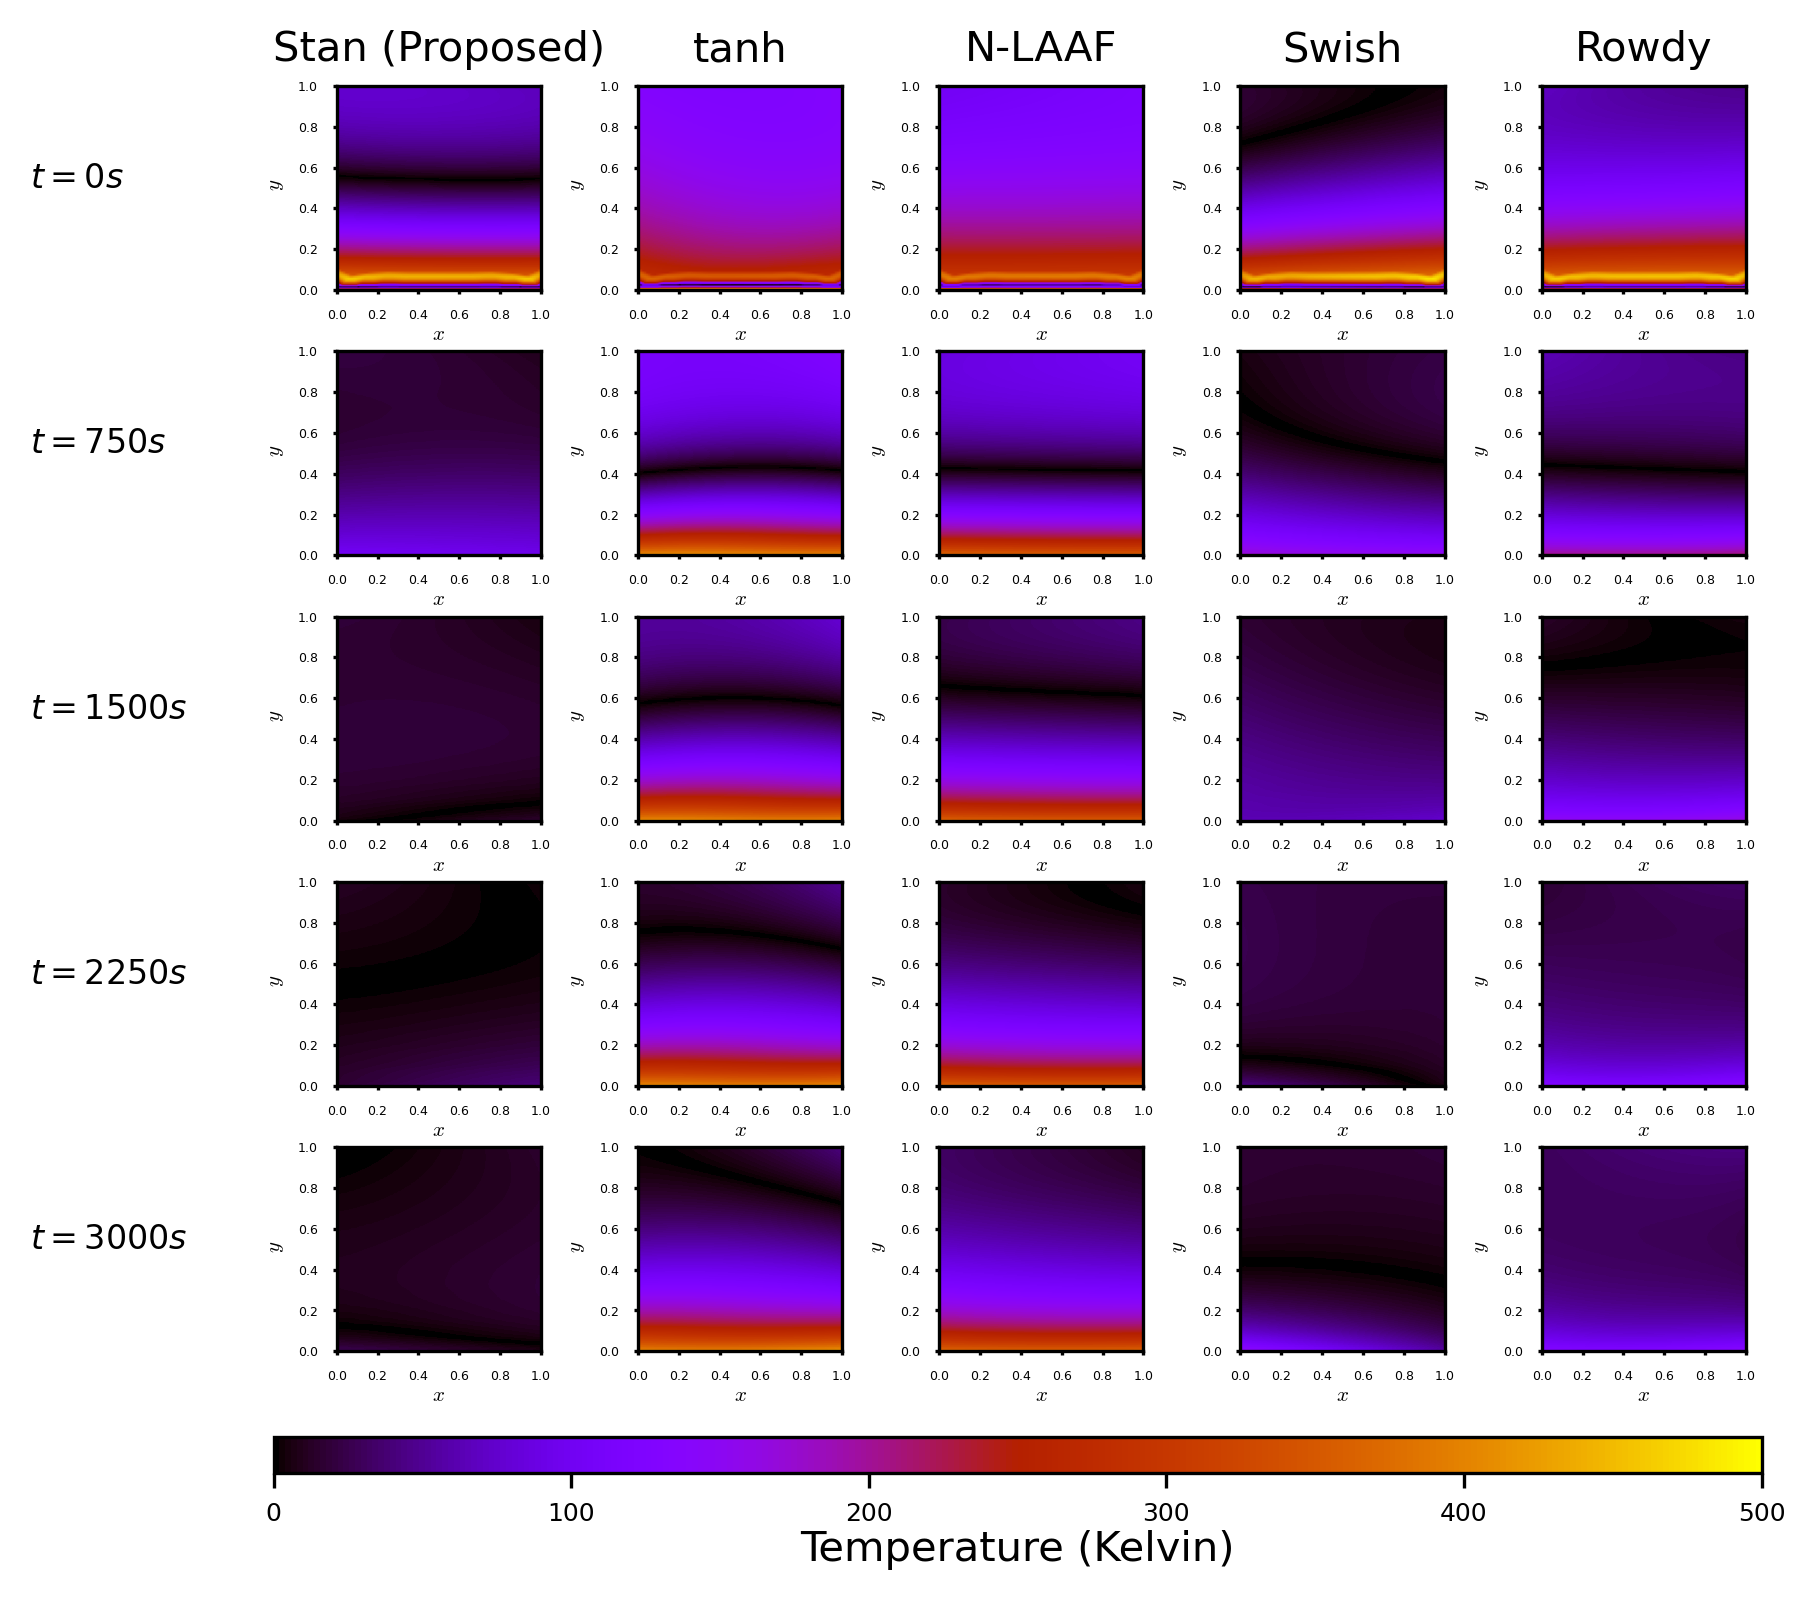

In [10]:
fig, ax = plt.subplots(5,6)
fig.dpi=300
fig.tight_layout()

t_steps = [0,24,49,74,99]

ax[0,0].set_aspect(aspect = 1/80)
ax[0,0].axis('off')
ax[0,0].text(0,0.5,"$t=0s$",fontsize=8)

ax[1,0].set_aspect(aspect = 1/80)
ax[1,0].axis('off')
ax[1,0].text(0,0.5,"$t=750s$",fontsize=8)

ax[2,0].set_aspect(aspect = 1/80)
ax[2,0].axis('off')
ax[2,0].text(0,0.5,"$t=1500s$",fontsize=8)

ax[3,0].set_aspect(aspect = 1/80)
ax[3,0].axis('off')
ax[3,0].text(0,0.5,"$t=2250s$",fontsize=8)

ax[4,0].set_aspect(aspect = 1/80)
ax[4,0].axis('off')
ax[4,0].text(0,0.5,"$t=3000s$",fontsize=8)

for R in range(5):

    cmap = plt.cm.gnuplot

    u_fea_3d = np.flipud(np.transpose(u_fea[:,t_steps[R]].reshape(100,100)))
    #ax[R,0].figure.set_size_inches(50,50)
#     img = ax[R,1].imshow(u_fea_3d-u_fea_3d,vmin = 300,vmax = 1000,cmap = cmap,extent=[0,1,0,1],aspect = 1)

#     ax[R,1].set_xlabel('$x$', fontsize=5, math_fontfamily='cm', labelpad=0.5)
#     ax[R,1].set_ylabel(' $y$',fontsize=5, math_fontfamily='cm', labelpad=0.5)

#     ax[R,1].tick_params(axis='x', labelsize=3,length = 1)
#     ax[R,1].tick_params(axis='y', labelsize=3,length = 1)

#     ax[R,1].yaxis.set_label_coords(-0.25,0.5)

    for i in range(1,6):
        #ax[R,i].figure.set_size_inches(50,50)
        u_pred_3d = u_pred[:,i-1].reshape(100,100,100,order = 'F')
        img = ax[R,i].imshow(np.abs(np.flipud(u_pred_3d[:,:,t_steps[R]])-u_fea_3d),vmin = 0,vmax = 500,cmap = cmap,extent=[0,1,0,1],aspect = 1)

        ax[R,i].set_xlabel('$x$', fontsize=5, math_fontfamily='cm', labelpad=0.5)
        ax[R,i].set_ylabel(' $y$',fontsize=5, math_fontfamily='cm', labelpad=0.5)

        ax[R,i].tick_params(axis='x', labelsize=3,length = 1)
        ax[R,i].tick_params(axis='y', labelsize=3,length = 1)

        ax[R,i].yaxis.set_label_coords(-0.25,0.5)


cbaxes = fig.add_axes([0.20, -0.005, 0.775, 0.025]) 

#cbar = fig.colorbar(img, ax=ax,location = 'bottom',orientation = 'horizontal', aspect = 50, panchor = (0,10),pad = 0.9)
cbar = fig.colorbar(img,cax = cbaxes,orientation = 'horizontal', aspect = 1/50, panchor = (0,10),pad = 0.9)
cbar.ax.tick_params(labelsize=6,labelbottom = True,labeltop = False, bottom =True, top = False) 
cbar.ax.get_xaxis().labelpad = 1
cbar.ax.set_xlabel('Temperature (Kelvin)')

# ax[0,0].set_title('Time Steps',fontsize=8, math_fontfamily='cm')
# ax[0,1].set_title('FEA',fontsize=10, math_fontfamily='cm')
ax[0,1].set_title('Stan (Proposed)',fontsize=10, math_fontfamily='cm')
ax[0,2].set_title('tanh',fontsize=10, math_fontfamily='cm')
ax[0,3].set_title('N-LAAF',fontsize=10, math_fontfamily='cm')
ax[0,4].set_title('Swish',fontsize=10, math_fontfamily='cm')
ax[0,5].set_title('Rowdy',fontsize=10, math_fontfamily='cm')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.3)
plt.savefig('HTTP_error_comparison.pdf', format='pdf',pad_inches=0, bbox_inches='tight')

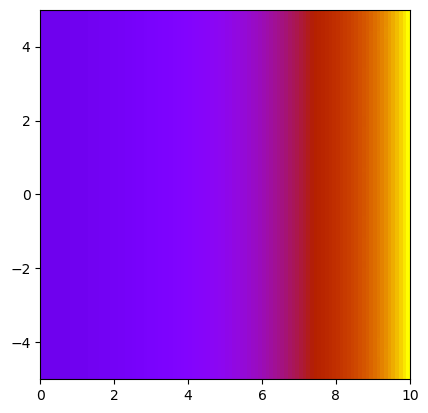

In [11]:
plt.imshow(np.flipud(np.transpose(u_fea_3d)),vmin = 300,vmax = 1000,cmap = cmap,extent=[0,10,-5,5],aspect = 1)

In [12]:
from itertools import product, combinations
from scipy.interpolate import griddata


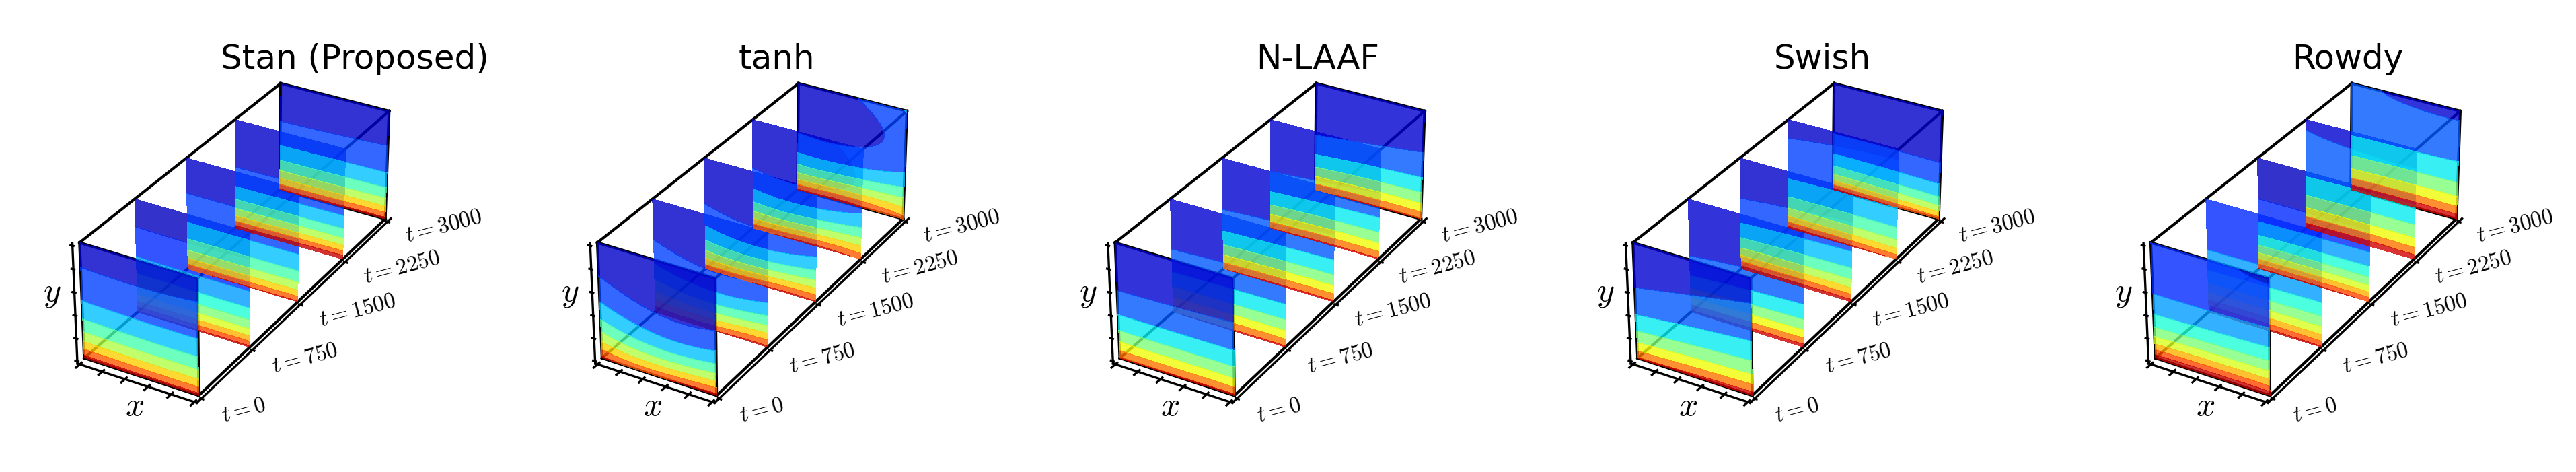

In [13]:
titles = ["Stan (Proposed)","tanh","N-LAAF","Swish","Rowdy"]
fig = plt.figure(figsize=plt.figaspect(0.2))
#fig,ax = plt.subplots(1,5)

r1 = [lb_xyt[0],ub_xyt[0]]
r2 = [lb_xyt[2],3000*ub_xyt[2]]
r3 = [lb_xyt[1],ub_xyt[1]]
fig.dpi=300


for i in range(5):
    u_pred_3d = u_pred[:,i].reshape(100,100,100,order = 'F')
    ax = fig.add_subplot(1,5,i+1,projection='3d')


    ax.grid(False)

    X_plot, Y_plot = np.meshgrid(x,y)
    X1 = np.hstack((X_plot.flatten('F').reshape(-1,1),Y_plot.flatten('F').reshape(-1,1)))


    u_pred_plot = u_pred_3d[:,:,0] 
    UU_star = np.transpose(griddata(X1, u_pred_plot.flatten(), (X_plot, Y_plot), method='cubic'))
    ax.contourf(X_plot,UU_star,Y_plot, zdir = 'y', offset = 0, cmap='jet', alpha = 0.8)


    for n in range(4):
        u_pred_plot = u_pred_3d[:,:,99-n*25] 
        UU_star = np.transpose(griddata(X1, u_pred_plot.flatten(), (X_plot, Y_plot), method='cubic'))
        ax.contourf(X_plot,UU_star,Y_plot, zdir = 'y', offset = 3000 - n*750, cmap='jet', alpha = 0.8)

    for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
        if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
            ax.plot3D(*zip(s,e), color="k", linewidth = 1)       

    ax.tick_params(axis='y', labelsize=8)


    ax.set_xticklabels([])
    ax.set_zticklabels([])



    ax.set_yticks([0,750,1500,2250,3000])
    y_ticklabels = ["$t = 0$","$t = 750$","$t = 1500$","$t = 2250$","$t =3000$"] 
    ax.set_yticklabels(y_ticklabels,rotation=15,verticalalignment='baseline',horizontalalignment='left',math_fontfamily='cm')

    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                         tmp_planes[0], tmp_planes[1], 
                         tmp_planes[4], tmp_planes[5])

    ax.set_xlim3d(r1)
    ax.set_ylim3d(r2)
    ax.set_zlim3d(r3)
    ax.set_box_aspect((1,3, 1))


    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.text(0.35, 0, -0.4, '$x$',math_fontfamily='cm',fontsize = 12)
    ax.text(-0.35, 0, 0.4, '$y$',math_fontfamily='cm',fontsize = 12)
    
    ax.text(1.2, 0, 2.7,titles[i],math_fontfamily='cm',fontsize = 12)


plt.savefig(prob_name + 'prediction.pdf', format='pdf',pad_inches=0, bbox_inches='tight')

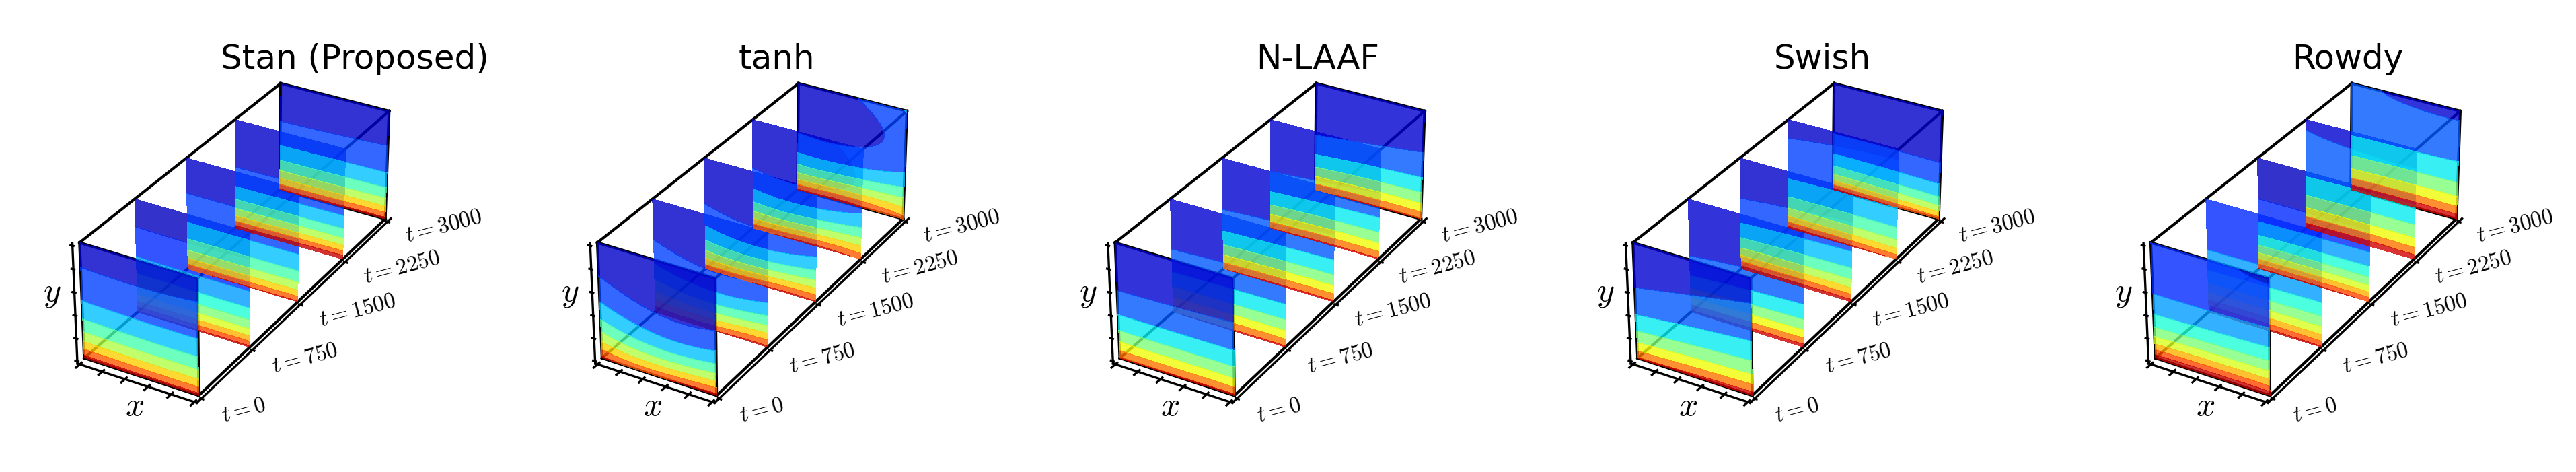

In [14]:
titles = ["Stan (Proposed)","tanh","N-LAAF","Swish","Rowdy"]
fig = plt.figure(figsize=plt.figaspect(0.2))
#fig,ax = plt.subplots(1,5)

r1 = [lb_xyt[0],ub_xyt[0]]
r2 = [lb_xyt[2],3000*ub_xyt[2]]
r3 = [lb_xyt[1],ub_xyt[1]]
fig.dpi=300


for i in range(5):
    u_pred_3d = u_pred[:,i].reshape(100,100,100,order = 'F')
    ax = fig.add_subplot(1,5,i+1,projection='3d')


    ax.grid(False)

    X_plot, Y_plot = np.meshgrid(x,y)
    X1 = np.hstack((X_plot.flatten('F').reshape(-1,1),Y_plot.flatten('F').reshape(-1,1)))


    u_pred_plot = u_pred_3d[:,:,0] 
    UU_star = np.transpose(griddata(X1, u_pred_plot.flatten(), (X_plot, Y_plot), method='cubic'))
    ax.contourf(X_plot,UU_star,Y_plot, zdir = 'y', offset = 0, cmap='jet', alpha = 0.8)


    for n in range(4):
        u_pred_plot = u_pred_3d[:,:,99-n*25] 
        UU_star = np.transpose(griddata(X1, u_pred_plot.flatten(), (X_plot, Y_plot), method='cubic'))
        ax.contourf(X_plot,UU_star,Y_plot, zdir = 'y', offset = 3000 - n*750, cmap='jet', alpha = 0.8)

    for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
        if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
            ax.plot3D(*zip(s,e), color="k", linewidth = 1)       

    ax.tick_params(axis='y', labelsize=8)


    ax.set_xticklabels([])
    ax.set_zticklabels([])



    ax.set_yticks([0,750,1500,2250,3000])
    y_ticklabels = ["$t = 0$","$t = 750$","$t = 1500$","$t = 2250$","$t =3000$"] 
    ax.set_yticklabels(y_ticklabels,rotation=15,verticalalignment='baseline',horizontalalignment='left',math_fontfamily='cm')

    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                         tmp_planes[0], tmp_planes[1], 
                         tmp_planes[4], tmp_planes[5])

    ax.set_xlim3d(r1)
    ax.set_ylim3d(r2)
    ax.set_zlim3d(r3)
    ax.set_box_aspect((1,3, 1))


    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.text(0.35, 0, -0.4, '$x$',math_fontfamily='cm',fontsize = 12)
    ax.text(-0.35, 0, 0.4, '$y$',math_fontfamily='cm',fontsize = 12)
    
    ax.text(1.2, 0, 2.7,titles[i],math_fontfamily='cm',fontsize = 12)


plt.savefig(prob_name + 'test.pdf', format='pdf',pad_inches=0, bbox_inches='tight')

In [15]:
layers = np.array([3,50,50,50,50,50,50,50,50,50,1])
device = 'cpu'
beta_init = 1.0

model_stan = Sequentialmodel(layers,beta_init)
model_stan.load_state_dict(torch.load('./stan/3D_HTTP_stan_8.pt'))
xyt_test_tensor = torch.from_numpy(xyt).float().to(device)


u_pred = model_stan.test()
u_pred_3d = u_pred.reshape(100,100,100,order = 'F')

NameError: name 'Sequentialmodel' is not defined

In [ ]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.flipud(u_pred_3d[:,:,50]),vmax =1000,vmin=300,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
fig.colorbar(img3, orientation='vertical')



In [ ]:
import subprocess
import os
import cv2

for i in range(100):
    #plt.imshow(img[i], cmap=cm.Greys_r)
    #fig, ax = 
    plt.subplots(1,1)
    img3 = plt.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=300,cmap = cmap,extent=[0,1,0,1],aspect = 1)
    plt.colorbar(img3, orientation='vertical')
    plt.savefig("stan_heat_%02d.eps" % i,pad_inches=0, bbox_inches='tight')

video_name = '3D_HTTP_stan_8.mp4'
# fourcc = cv2.CV_FOURCC(*'MP4V')
fourcc = cv2.VideoWriter_fourcc(*'MP4V')

images = []
for i in range(100):
    images.append("stan_heat_%02d.eps" % i)
#frame = cv2.imread(os.path.join(image_folder, images[0]))


In [ ]:
frame = cv2.imread(images[0])
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))
# video._fourcc = cv2.VideoWriter_fourcc(*'MP4V')

for image in images:
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()    

In [ ]:
frame

In [ ]:
#Relative Error
print('Relative Error')
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

In [ ]:
test_loss_stan =  data_stan['test_mse_loss']
test_loss_tanh =  data_tanh['test_mse_loss']
test_loss_atanh =  data_atanh['test_mse_loss']
test_loss_swish =  data_swish['test_mse_loss']
test_loss_rowdy =  data_rowdy['test_mse_loss']


mean_test_loss_stan = np.zeros((num_steps,1))
mean_test_loss_tanh = np.zeros((num_steps,1))
mean_test_loss_atanh = np.zeros((num_steps,1))
mean_test_loss_swish = np.zeros((num_steps,1))
mean_test_loss_rowdy = np.zeros((num_steps,1))


for i in range(10):
    mean_test_loss_stan = mean_test_loss_stan + test_loss_stan[i,:num_steps].reshape(-1,1)
    mean_test_loss_tanh = mean_test_loss_tanh + test_loss_tanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_atanh = mean_test_loss_atanh + test_loss_atanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_swish = mean_test_loss_swish + test_loss_swish[i,:num_steps].reshape(-1,1)
    mean_test_loss_rowdy = mean_test_loss_rowdy + test_loss_rowdy[i,:num_steps].reshape(-1,1)
    
        
mean_test_loss_stan = mean_test_loss_stan/10
mean_test_loss_tanh = mean_test_loss_tanh/10
mean_test_loss_atanh = mean_test_loss_atanh/10
mean_test_loss_swish = mean_test_loss_swish/10
mean_test_loss_rowdy = mean_test_loss_rowdy/10

print('MSE')
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

In [ ]:
print('Total Time')
print(np.mean(data_stan['Time']))
print(np.mean(data_tanh['Time']))
print(np.mean(data_atanh['Time']))
print(np.mean(data_swish['Time']))
print(np.mean(data_rowdy['Time']))

In [ ]:
max_time = np.max(np.vstack((data_stan['Time'],data_tanh['Time'],data_atanh['Time'],data_swish['Time'],data_rowdy['Time'])))

ttime_stan = data_stan['Thresh Time']
ttime_tanh = data_tanh['Thresh Time']
ttime_atanh = data_atanh['Thresh Time']
ttime_swish = data_swish['Thresh Time']
ttime_rowdy = data_rowdy['Thresh Time']

ttime_stan[np.isnan(ttime_stan)] = max_time
ttime_tanh[np.isnan(ttime_tanh)] = max_time
ttime_atanh[np.isnan(ttime_atanh)] = max_time
ttime_swish[np.isnan(ttime_swish)] = max_time
ttime_rowdy[np.isnan(ttime_rowdy)] = max_time

print('Threshold Time')
print(np.mean(ttime_stan))
print(np.mean(ttime_tanh))
print(np.mean(ttime_atanh))
print(np.mean(ttime_swish))
print(np.mean(ttime_rowdy))

In [ ]:
tep_stan = data_stan['Thresh epoch']
tep_tanh = data_tanh['Thresh epoch']
tep_atanh = data_atanh['Thresh epoch']
tep_swish = data_swish['Thresh epoch']
tep_rowdy = data_rowdy['Thresh epoch']

print('Threshold Epoch')
print(np.mean(tep_stan))
print(np.mean(tep_tanh))
print(np.mean(tep_atanh))
print(np.mean(tep_swish))
print(np.mean(tep_rowdy))